In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import sys
import math
import pybedtools
import hicstraw
from tqdm.notebook import tqdm

# Import custom libraries
sys.path.append("..")
import process_hic_contacts_inter as phc

In [2]:
# Specify directories and relevant information
genome_dir = '/home/louiscam/projects/gpcr/data/genome_data/'
raw_hic_dir = '/home/louiscam/projects/gpcr/data/hic_data/IMR90/'
balanced_hic_dir = '/home/louiscam/projects/gpcr/save/processed_hic_data/'
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
arrowhead_dir = '/home/louiscam/projects/gpcr/save/processed_hic_domains/arrowhead/'
cell_type = 'IMR90'
quality = 'MAPQGE30'
intra_norm = 'KR'
inter_norm = 'GWKR'
resol = 250000
normalization_list = ['NONE', 'KR']
resolution_list = [5000, 10000, 25000]
chromosomes_list = np.arange(1, 22+1, 1)

In [3]:
# Pick parameters
normalization = normalization_list[1]
resolution = resolution_list[2]
chrom = chromosomes_list[20]

In [4]:
# Load chromosome size
df_sizes = phc.get_chrom_sizes(genome_dir, resol)
dict_size = {
    df_sizes.loc[idx, 'chr']: df_sizes.loc[idx, 'size'] for idx in df_sizes.index
}
dict_size_tad = {
    df_sizes.loc[idx, 'chr']: (df_sizes.loc[idx, 'size']//resolution)*resolution for idx in df_sizes.index
}

# Load TAD data for one chromosome

## Load raw TADs data

In [5]:
# Load TAD data
fname = arrowhead_dir+f'{normalization}/{resolution}/{chrom}/{resolution}_blocks.bedpe'
tads_df = pd.read_csv(fname, sep='\t', header=0)
tads_df = tads_df.drop(labels=0, axis=0)
tads_df[['x1', 'y1', 'x2', 'y2']] = tads_df[['x1', 'y1', 'x2', 'y2']].astype(int)
tads_df.loc[:, 'length'] = tads_df['x2']-tads_df['x1']

In [6]:
# Order the domains
tads_df = tads_df.sort_values(by=['x1', 'x2'])
tads_df = tads_df.reset_index(drop=True)

In [7]:
# Visualize TADs dataframe
tads_df.head()

,#chr1,x1,x2,chr2,y1,y2,name,score,strand1,strand2,color,score.1,uVarScore,lVarScore,upSign,loSign,length
0,21,15675000,16900000,21.0,15675000,16900000,.,.,.,.,"255,255,0",1.459304,0.114742,0.082692,0.889600,0.841600,1225000
1,21,15775000,16125000,21.0,15775000,16125000,.,.,.,.,"255,255,0",0.821033,0.050248,0.026344,0.625000,0.553571,350000
2,21,16075000,16850000,21.0,16075000,16850000,.,.,.,.,"255,255,0",0.988380,0.089844,0.073884,0.558594,0.808594,775000
3,21,17250000,18625000,21.0,17250000,18625000,.,.,.,.,"255,255,0",1.366457,0.057662,0.055259,0.840561,0.911990,1375000
4,21,17300000,17725000,21.0,17300000,17725000,.,.,.,.,"255,255,0",0.966134,0.040188,0.031817,0.740741,0.666667,425000


## Describe raw TADs

In [8]:
# Display stats
print(f'Total number of TADs = {tads_df.shape[0]}')
print('Descriptive statistics:')
print(tads_df['length'].describe())

Total number of TADs = 44
Descriptive statistics:
count    4.400000e+01
mean     7.210227e+05
std      4.868009e+05
min      3.000000e+05
25%      4.187500e+05
50%      5.250000e+05
75%      8.500000e+05
max      2.700000e+06
Name: length, dtype: float64


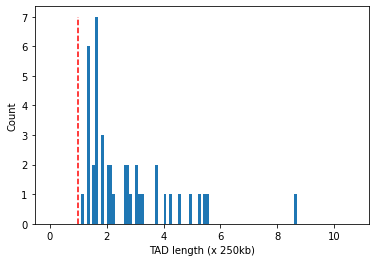

In [9]:
# Distribution of TAD lengths in terms of 250kb
%matplotlib inline
plt.figure()
h = plt.hist(
    tads_df['length']/resol,
    bins=np.arange(0, (tads_df['length']/resol).max(), 0.1)
)
plt.vlines(x=1, ymin=0, ymax=h[0].max(), color='red', linestyle='dashed')
plt.xlabel('TAD length (x 250kb)')
plt.ylabel('Count')
plt.show()

## Visualize raw TADs

In [10]:
# Create mask heatmap
tad_map = pd.DataFrame(
    0, 
    index=np.arange(0, dict_size_tad[str(chrom)], resolution), 
    columns=np.arange(0, dict_size_tad[str(chrom)], resolution)
)
for idx in tqdm(tads_df.index):
    x1 = tads_df.loc[idx, 'x1']
    y1 = tads_df.loc[idx, 'y1']
    x2 = tads_df.loc[idx, 'x2']
    y2 = tads_df.loc[idx, 'y2']
    score = tads_df.loc[idx, 'score.1']
    tad_map.loc[np.arange(x1, x2+1, resolution), np.arange(y1, y2+1, resolution)] = score
tad_map.index.name = 'Loci'
tad_map.columns.name = 'Loci'

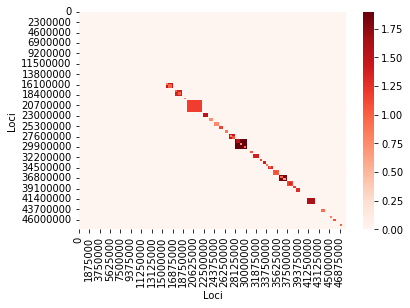

In [12]:
# Visualize heatmap
%matplotlib inline
plt.figure()
sns.heatmap(
    data=tad_map,
    cmap='Reds',
)
plt.show()

## Visualize raw TADs data overlap

In [13]:
# Visualize amount of overlap between TADs
tad_overlap_df = pd.DataFrame(
    0, 
    index=tads_df.index, 
    columns=tads_df.index
)
for idx1, idx2 in tqdm(list(itertools.combinations(tads_df.index, 2))):
    
    x1 = tads_df.loc[idx1, 'x1']
    x2 = tads_df.loc[idx1, 'x2']
    x1_prime = tads_df.loc[idx2, 'x1']
    x2_prime = tads_df.loc[idx2, 'x2']
    
    if (x1_prime<x2) & (x2_prime<x2):
        intersection = (x2_prime-x1_prime)**2
    elif (x1_prime<x2) & (x2_prime>=x2):
        intersection = (x2-x1_prime)**2
    else:
        intersection = 0
        
    union = (x2-x1)**2+(x2_prime-x1_prime)**2-intersection
    i_over_u = intersection/union
    tad_overlap_df.loc[idx1, idx2] = i_over_u
    
tad_overlap_df = tad_overlap_df+tad_overlap_df.T
tad_overlap_df = tad_overlap_df+np.diag(np.repeat(1, tad_overlap_df.shape[0]))

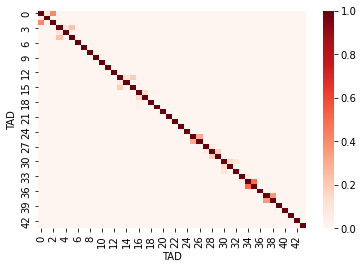

In [14]:
# Display overlap between TADs
plt.figure()
sns.heatmap(
    data=tad_overlap_df,
    cmap='Reds',
    vmin=0,
    vmax=1,
)
plt.xlabel('TAD')
plt.ylabel('TAD')
plt.show()

# Process overlapping and nested domains for one chromosome

## Drop nested and merge overlapping domains

In [15]:
# Select TAD location columns
domainsDT_tmp = tads_df[['#chr1', 'x1', 'x2']].copy()
domainsDT_tmp.columns = ['chromo', 'start', 'end']
domainsDT_tmp.loc[:, 'start'] = domainsDT_tmp['start']+1

In [16]:
# Order the domains
domainsDT_tmp = domainsDT_tmp.sort_values(by=['start', 'end'], ascending=[True, True])
domainsDT_tmp = domainsDT_tmp.drop_duplicates()

In [17]:
# Discard nested and overlapping domains
domainsDT = pd.DataFrame(columns=["chromo", "start", "end"])
n_all = len(domainsDT_tmp)
n_nested = 0
n_overlapping = 0

for i in tqdm(domainsDT_tmp.index):
    curr_chromo = domainsDT_tmp.loc[i]["chromo"]
    curr_start = domainsDT_tmp.loc[i]["start"]
    curr_end = domainsDT_tmp.loc[i]["end"]
    # if there is a nested domain, discard it
    if any(
        (domainsDT_tmp["start"].drop(labels=[i]) <= curr_start) &
        (domainsDT_tmp["end"].drop(labels=[i]) >= curr_end)
    ):
        n_nested = n_nested+1
        continue
    # if the current domain overlaps previous domain(s), merge it
    if any(curr_start < domainsDT["end"]):
        n_overlapping = n_overlapping+1
        domainsDT.iloc[-1, 2] = curr_end
        continue
    curr_line = pd.DataFrame(
        {"chromo": curr_chromo, "start": curr_start, "end": curr_end}, index=[0]
    )
    domainsDT = pd.concat([domainsDT, curr_line], ignore_index=True)
    # ensure ordering of the domains
    domainsDT = domainsDT.sort_values(["start", "end"])
    
domainsDT.loc[:, 'length'] = domainsDT['end']-domainsDT['start']+1

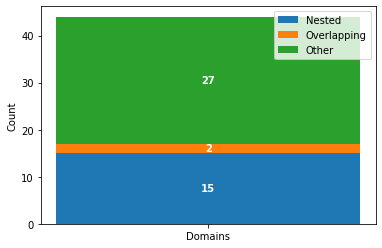

In [18]:
# Stacked barchart showing the number of nested, overlapping, and other domains
n_other = n_all-n_nested-n_overlapping

fig, ax = plt.subplots()

ax.bar(0, n_nested, align='center', label='Nested')
ax.bar(0, n_overlapping, bottom=n_nested, align='center', label='Overlapping')
ax.bar(0, n_other, bottom=n_nested+n_overlapping, align='center', label='Other')

ax.text(0, n_nested/2, str(n_nested), ha='center', va='center', color='white', weight='bold')
ax.text(0, n_nested+n_overlapping/2, str(n_overlapping), ha='center', va='center', color='white', weight='bold')
ax.text(0, n_nested+n_overlapping+n_other/2, str(n_other), ha='center', va='center', color='white', weight='bold')

ax.set_xticks([0])
ax.set_xticklabels(['Domains'])
ax.set_ylabel('Count')
ax.legend()

plt.show()

## Describe processed TADs

In [19]:
# Display stats
print(f'Total number of TADs = {domainsDT.shape[0]}')
print('Descriptive statistics:')
print(domainsDT['length'].describe())

Total number of TADs = 27
Descriptive statistics:
count         27
unique        22
top       350000
freq           2
Name: length, dtype: int64


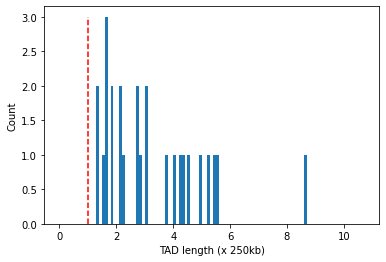

In [20]:
# Distribution of TAD lengths in terms of 250kb
plt.figure()
h = plt.hist(
    domainsDT['length']/resol,
    bins=np.arange(0, (domainsDT['length']/resol).max(), 0.1)
)
plt.vlines(x=1, ymin=0, ymax=h[0].max(), color='red', linestyle='dashed')
plt.xlabel('TAD length (x 250kb)')
plt.ylabel('Count')
plt.show()

## Visualize processed TADs

In [21]:
# Create mask heatmap
processed_tad_map = pd.DataFrame(
    0, 
    index=np.arange(0, dict_size_tad[str(chrom)], resolution), 
    columns=np.arange(0, dict_size_tad[str(chrom)], resolution)
)
for idx in tqdm(domainsDT.index):
    x1 = domainsDT.loc[idx, 'start']-1
    y1 = domainsDT.loc[idx, 'start']-1
    x2 = domainsDT.loc[idx, 'end']
    y2 = domainsDT.loc[idx, 'end']
    score = 1
    processed_tad_map.loc[np.arange(x1, x2+1, resolution), np.arange(y1, y2+1, resolution)] = score
processed_tad_map.index.name = 'Loci'
processed_tad_map.columns.name = 'Loci'

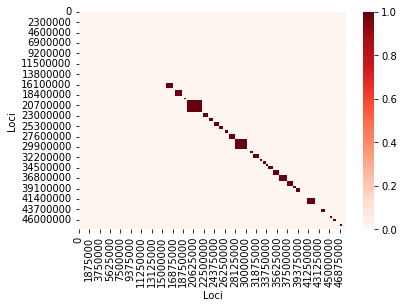

In [23]:
# Visualize heatmap
%matplotlib inline
plt.figure()
sns.heatmap(
    data=processed_tad_map,
    cmap='Reds',
)
plt.show()

## Visualize processed TADs overlap

In [24]:
# Visualize amount of overlap between TADs
tad_overlap_df = pd.DataFrame(
    0, 
    index=domainsDT.index, 
    columns=domainsDT.index
)
for idx1, idx2 in tqdm(list(itertools.combinations(domainsDT.index, 2))):
    
    x1 = domainsDT.loc[idx1, 'start']
    x2 = domainsDT.loc[idx1, 'end']
    x1_prime = domainsDT.loc[idx2, 'start']
    x2_prime = domainsDT.loc[idx2, 'end']
    
    if (x1_prime<x2) & (x2_prime<x2):
        intersection = (x2_prime-x1_prime)**2
    elif (x1_prime<x2) & (x2_prime>=x2):
        intersection = (x2-x1_prime)**2
    else:
        intersection = 0
        
    union = (x2-x1)**2+(x2_prime-x1_prime)**2-intersection
    i_over_u = intersection/union
    tad_overlap_df.loc[idx1, idx2] = i_over_u
    
tad_overlap_df = tad_overlap_df+tad_overlap_df.T
tad_overlap_df = tad_overlap_df+np.diag(np.repeat(1, tad_overlap_df.shape[0]))

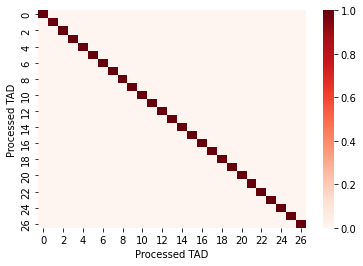

In [25]:
# Display overlap between TADs
plt.figure()
sns.heatmap(
    data=tad_overlap_df,
    cmap='Reds',
    vmin=0,
    vmax=1,
)
plt.xlabel('Processed TAD')
plt.ylabel('Processed TAD')
plt.show()

# Analyze impact of processing for all chromosomes across all settings

## Load unprocessed TADs list

In [26]:
# Store unprocessed TADs list for all chromosomes in a dictionary
unprocessed_tads_dict = {}
for normalization in normalization_list:
    for resolution in resolution_list:
        fname = arrowhead_dir+f"{normalization}/{resolution}/unprocessed_tads_list.csv"
        value = pd.read_csv(fname, header=0, index_col=0)
        value = value.reset_index(drop=True)
        key = f"tad_{normalization}_{resolution}"
        unprocessed_tads_dict[key] = value

## Load processed TADs list

In [27]:
# Store processed TADs list for all chromosomes in a dictionary
processed_tads_dict = {}
for normalization in normalization_list:
    for resolution in resolution_list:
        fname = arrowhead_dir+f"{normalization}/{resolution}/processed_tads_list.csv"
        value = pd.read_csv(fname, header=0, index_col=0)
        value = value.reset_index(drop=True)
        key = f"tad_{normalization}_{resolution}"
        processed_tads_dict[key] = value

## Compare unprocessed and processed TADs lists

### Number of TADs before and after processing

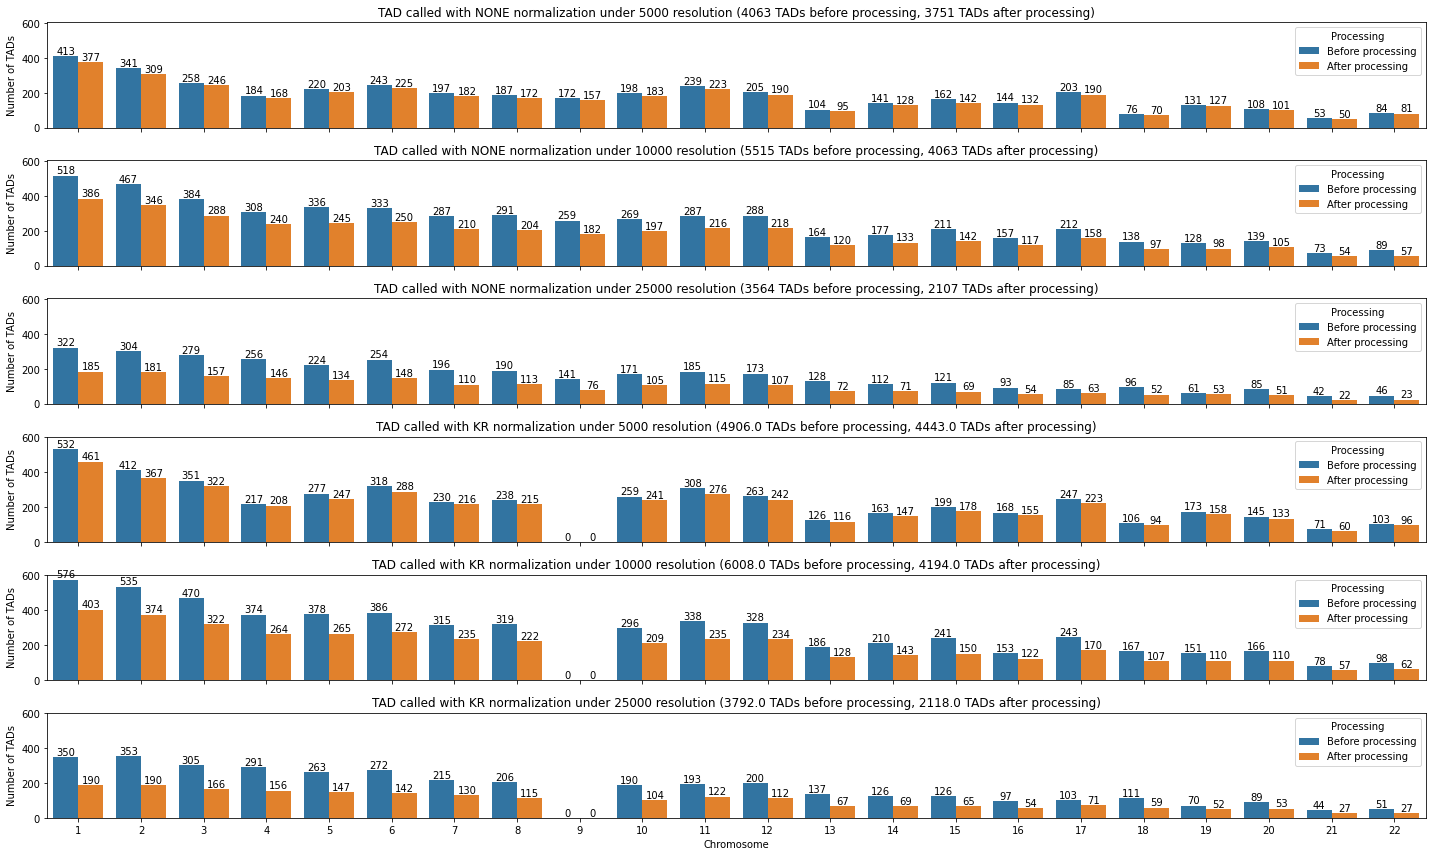

In [41]:
# Plot barplots showing the number of TADs before and after filtering
fig, axes = plt.subplots(nrows=len(processed_tads_dict.keys()), ncols=1, figsize=(20, 12), sharex=True, sharey=True)

# Plot the histograms on each subplot
for i, k in enumerate(processed_tads_dict.keys()):
    _, normalization, resolution = k.split('_')
    
    # Get size of unprocessed and processed TADs
    unprocessed_size_df = unprocessed_tads_dict[k].groupby('chromo').size().to_frame('Before processing')
    processed_size_df = processed_tads_dict[k].groupby('chromo').size().to_frame('After processing')
    size_df = pd.concat([unprocessed_size_df, processed_size_df], axis=1)
    
    # Check if all chromosomes are present -- if not, add 0 size
    for chrom in list(set(chromosomes_list)-set(size_df.index)):
        size_df.loc[chrom, :] = [0, 0]
    
    # Create barplot
    size_df_long = size_df.reset_index().melt(id_vars='chromo', var_name='Processing', value_name='Value')
    n_tads_before_processing = size_df_long.groupby('Processing')['Value'].sum()['Before processing']
    n_tads_after_processing = size_df_long.groupby('Processing')['Value'].sum()['After processing']
    sns.barplot(x='chromo', y='Value', hue='Processing', data=size_df_long, ax=axes[i])
    axes[i].set_ylabel('Number of TADs')
    axes[i].set_xlabel('')
    axes[i].set_title(
        f'TAD called with {normalization} normalization under {resolution} resolution ({n_tads_before_processing} TADs before processing, {n_tads_after_processing} TADs after processing)'
    )
    
    # Add bar values
    for p in axes[i].patches:
        height = p.get_height()
        axes[i].annotate(
            str(int(height)), (p.get_x() + p.get_width() / 2, height), 
            ha='center', 
            va='bottom',
            fontsize=10
        )

# Set common x-axis label
plt.xlabel('Chromosome')

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()

### Distribution of TAD length before and after processing

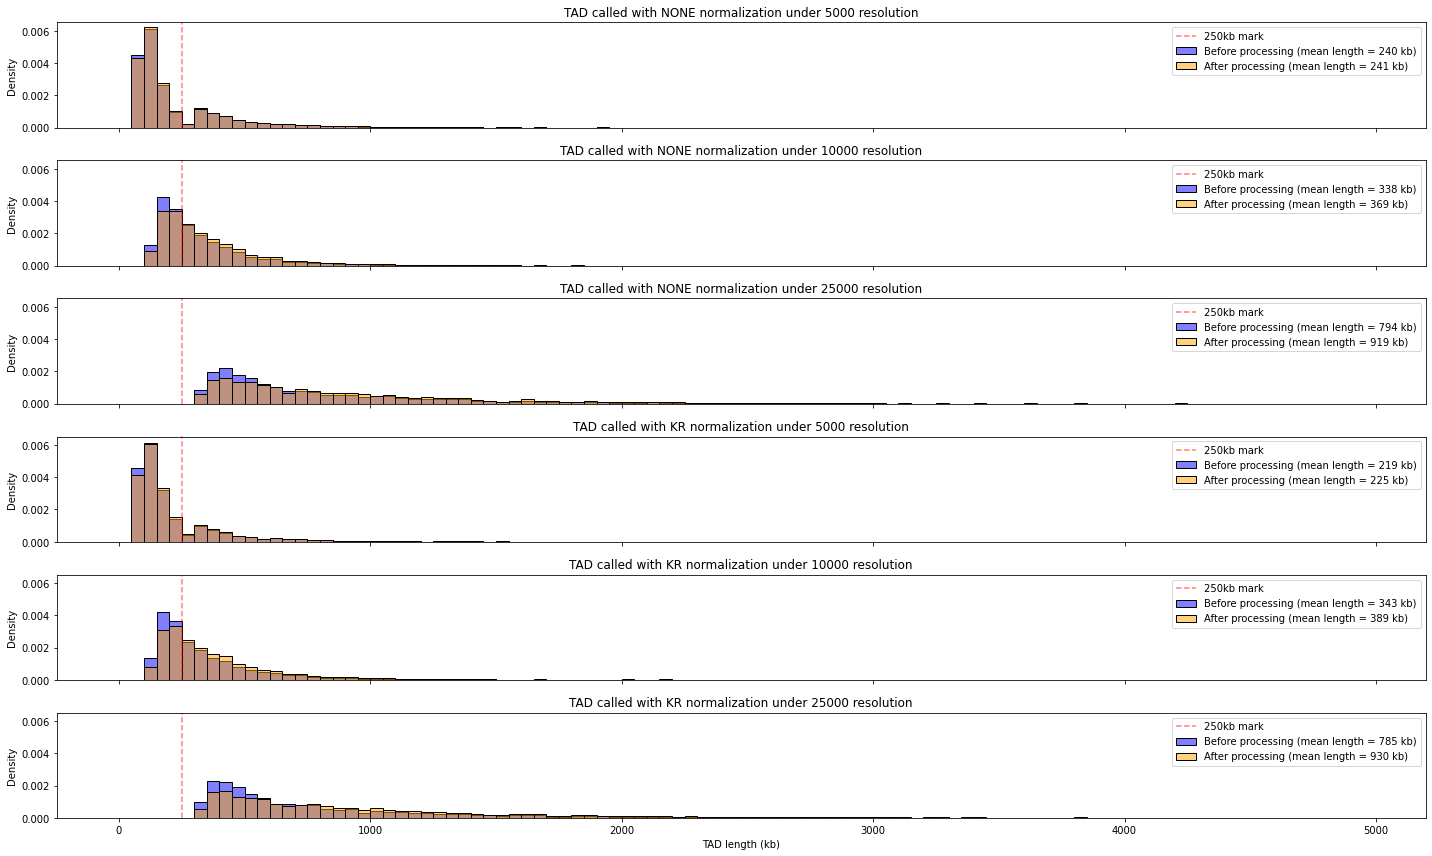

In [42]:
# Plot hisplots showing the distribution of TAD lengths before and after filtering
fig, axes = plt.subplots(nrows=len(processed_tads_dict.keys()), ncols=1, figsize=(20, 12), sharex=True, sharey=True)

# Plot the histograms on each subplot
for i, k in enumerate(processed_tads_dict.keys()):
    _, normalization, resolution = k.split('_')
    
    # Get size of unprocessed and processed TADs
    unprocessed_length_df = (unprocessed_tads_dict[k][['length']]/1000).copy()
    unprocessed_length_df.loc[:, 'Processing'] = 'Before processing'
    unprocessed_length_mean = int(unprocessed_length_df['length'].mean())
    processed_length_df = (processed_tads_dict[k][['length']]/1000).copy()
    processed_length_df.loc[:, 'Processing'] = 'After processing'
    processed_length_mean = int(processed_length_df['length'].mean())

    # Plot histplot for "Before processing"
    sns.histplot(
        x='length', 
        bins=np.arange(0, 5000, 50),
        stat='density',
        data=unprocessed_length_df, 
        ax=axes[i],
        color='blue',
        alpha=0.5,
        label=f'Before processing (mean length = {unprocessed_length_mean} kb)'
    )
    
    # Plot histplot for "After processing"
    sns.histplot(
        x='length', 
        bins=np.arange(0, 5000, 50),
        stat='density',
        data=processed_length_df, 
        ax=axes[i],
        color='orange',
        alpha=0.5,
        label=f'After processing (mean length = {processed_length_mean} kb)'
    )
    
    axes[i].axvline(x=250, ymin=0, ymax=100, color='red', alpha=0.5, linestyle='--', label='250kb mark')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'TAD called with {normalization} normalization under {resolution} resolution')
    axes[i].legend()

# Set common x-axis label
plt.xlabel('TAD length (kb)')

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()

## Coverage of processed TADs

In [30]:
# Create an appropriate dataframe containing the size of each chromosome
df_sizes2 = df_sizes[['chr', 'size']]
df_sizes2.columns = ['chromo', 'size']
df_sizes2 = df_sizes2[df_sizes2['chromo'].isin(map(str, chromosomes_list))]
df_sizes2['chromo'] = df_sizes2['chromo'].astype(int)
df_sizes2 = df_sizes2.set_index('chromo')
df_sizes2 = df_sizes2.sort_index()

### Coverage of the whole genome

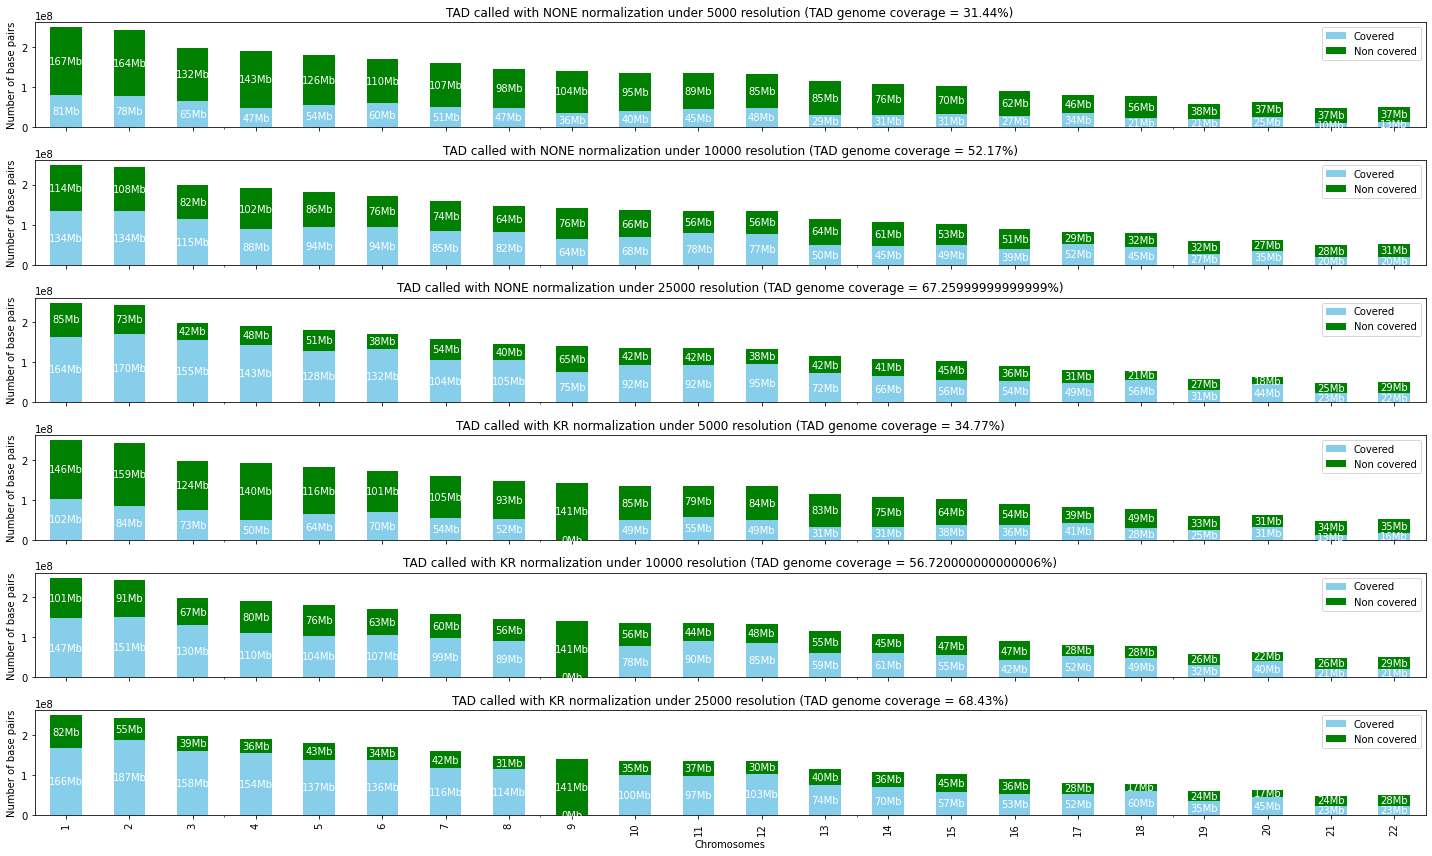

In [43]:
# Barplot of the number of base pairs covered by TADs for each chromosome
fig, axes = plt.subplots(nrows=len(processed_tads_dict.keys()), ncols=1, figsize=(20, 12), 
                         sharex=True, sharey=True)

# Plot the histograms on each subplot
for i, k in enumerate(processed_tads_dict.keys()):
    # Draw stacked barplot
    _, normalization, resolution = k.split('_')
    processed_tads_df = processed_tads_dict[k]
    coverage_tads_df = processed_tads_df.groupby('chromo')['length'].sum().to_frame('Covered')
    # Check if all chromosomes are present -- if not, add 0 size
    for chrom in list(set(chromosomes_list)-set(coverage_tads_df.index)):
        coverage_tads_df.loc[chrom, :] = [0]
    coverage_tads_df = coverage_tads_df.sort_index().astype(int)
    coverage_tads_df.loc[:, 'Non covered'] = df_sizes2['size']-coverage_tads_df['Covered']
    # Compute proportion of genome covered by TADs
    n_bp_genome = coverage_tads_df.sum().sum()
    n_bp_covered = coverage_tads_df['Covered'].sum()
    prop_bp_covered = np.round(n_bp_covered/n_bp_genome, 4)*100
    
    coverage_tads_df.plot(
        kind='bar', 
        stacked=True, 
        color=['skyblue', 'green'],
        
        ax=axes[i]
    )
    axes[i].set_ylabel('Number of base pairs')
    axes[i].set_title(f'TAD called with {normalization} normalization under {resolution} resolution (TAD genome coverage = {prop_bp_covered}%)')
    
    # Add values
    for container in axes[i].containers:
        for rect in container:
            width = rect.get_width()
            height = rect.get_height()
            x = rect.get_x() + width / 2
            y = rect.get_y() + height / 2
            label = f"{int(height//1000000)}Mb"
            axes[i].annotate(label, (x, y), ha='center', va='center', color='w')

# Set common x-axis label
plt.xlabel('Chromosomes')

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()

### Coverage of non-blacklisted genome

In [33]:
# Load all loci
with open(saving_dir+'all_active_loci.pkl', 'rb') as f:
    all_active_loci_from_clustering = pickle.load(f)
with open(saving_dir+'all_inactive_loci.pkl', 'rb') as f:
    all_inactive_loci_from_clustering = pickle.load(f)
all_loci = all_active_loci_from_clustering+all_inactive_loci_from_clustering
all_loci = sorted(all_loci)

In [34]:
# Load blacklisted genome at 250kb resolution
fdir = balanced_hic_dir+f"processed_hic_data_{cell_type}/final_BP{resol}_intra{intra_norm}_inter{inter_norm}/"
fname = fdir+f'blacklist_IMR90_{inter_norm}.pickle'
with open(fname, 'rb') as f:
    blacklist = pickle.load(f)

In [35]:
# Use the blackist to obtain non-blacklisted loci in BED format
non_blacklisted_loci = sorted(set(all_loci)-set(blacklist))
non_blacklisted_df = pd.DataFrame({'name': non_blacklisted_loci})
non_blacklisted_df.loc[:, 'chrom'] = 'chr'+non_blacklisted_df['name'].str.split('_', expand=True)[1]
non_blacklisted_df.loc[:, 'start'] = non_blacklisted_df['name'].str.split('_', expand=True)[3].astype(int)
non_blacklisted_df.loc[:, 'end'] = non_blacklisted_df['start']+resol
non_blacklisted_df = non_blacklisted_df[['chrom', 'start', 'end', 'name']]
non_blacklisted_bed = pybedtools.BedTool.from_dataframe(non_blacklisted_df)
non_blacklisted_bed = non_blacklisted_bed.sort()

In [36]:
# Create a dataframe counting the number of non-blacklisted base pairs per chromosome
non_blacklisted_df_per_chrom = non_blacklisted_df.copy()
non_blacklisted_df_per_chrom.loc[:, 'chrom'] = non_blacklisted_df_per_chrom['chrom'].str.strip('chr').astype(int)
non_blacklisted_df_per_chrom.loc[:, 'length'] = non_blacklisted_df_per_chrom['end']-non_blacklisted_df_per_chrom['start']
non_blacklisted_df_per_chrom
non_blacklisted_df_per_chrom = non_blacklisted_df_per_chrom[['chrom', 'start', 'end', 'length']]
non_blacklisted_df_per_chrom = non_blacklisted_df_per_chrom.groupby('chrom')['length'].sum().to_frame('Non blacklisted')

In [37]:
# Obtain TADs in BED format
processed_tads_df = processed_tads_dict[k]
processed_tads_df = processed_tads_df[['chromo', 'start', 'end']].copy()
processed_tads_df.columns = ['chrom', 'start', 'end']
processed_tads_df.loc[:, 'chrom'] = 'chr'+processed_tads_df['chrom'].astype(str)
processed_tads_df.loc[:, 'name'] = 'tad_'+processed_tads_df['chrom'].astype(str)+'_'
processed_tads_df.loc[:, 'name'] = processed_tads_df.loc[:, 'name'] + processed_tads_df['start'].astype(str)+'_'
processed_tads_df.loc[:, 'name'] = processed_tads_df.loc[:, 'name']+processed_tads_df['end'].astype(str)
processed_tads_bed = pybedtools.BedTool.from_dataframe(processed_tads_df)
processed_tads_bed = processed_tads_bed.sort()

# Intersect
out = processed_tads_bed.intersect(non_blacklisted_bed)
out = out.to_dataframe()
out.loc[:, 'chrom'] = out['chrom'].str.strip('chr').astype(int)
out.loc[:, 'length'] = out['end']-out['start']
out = out[['chrom', 'start', 'end', 'length']]
out = out.groupby('chrom')['length'].sum().to_frame('Covered')
# Check if all chromosomes are present -- if not, add 0 size
for chrom in list(set(chromosomes_list)-set(out.index)):
    out.loc[chrom, :] = [0]
out.loc[:, 'Non covered'] = non_blacklisted_df_per_chrom['Non blacklisted']-out['Covered']
out = out.sort_index().astype(int)

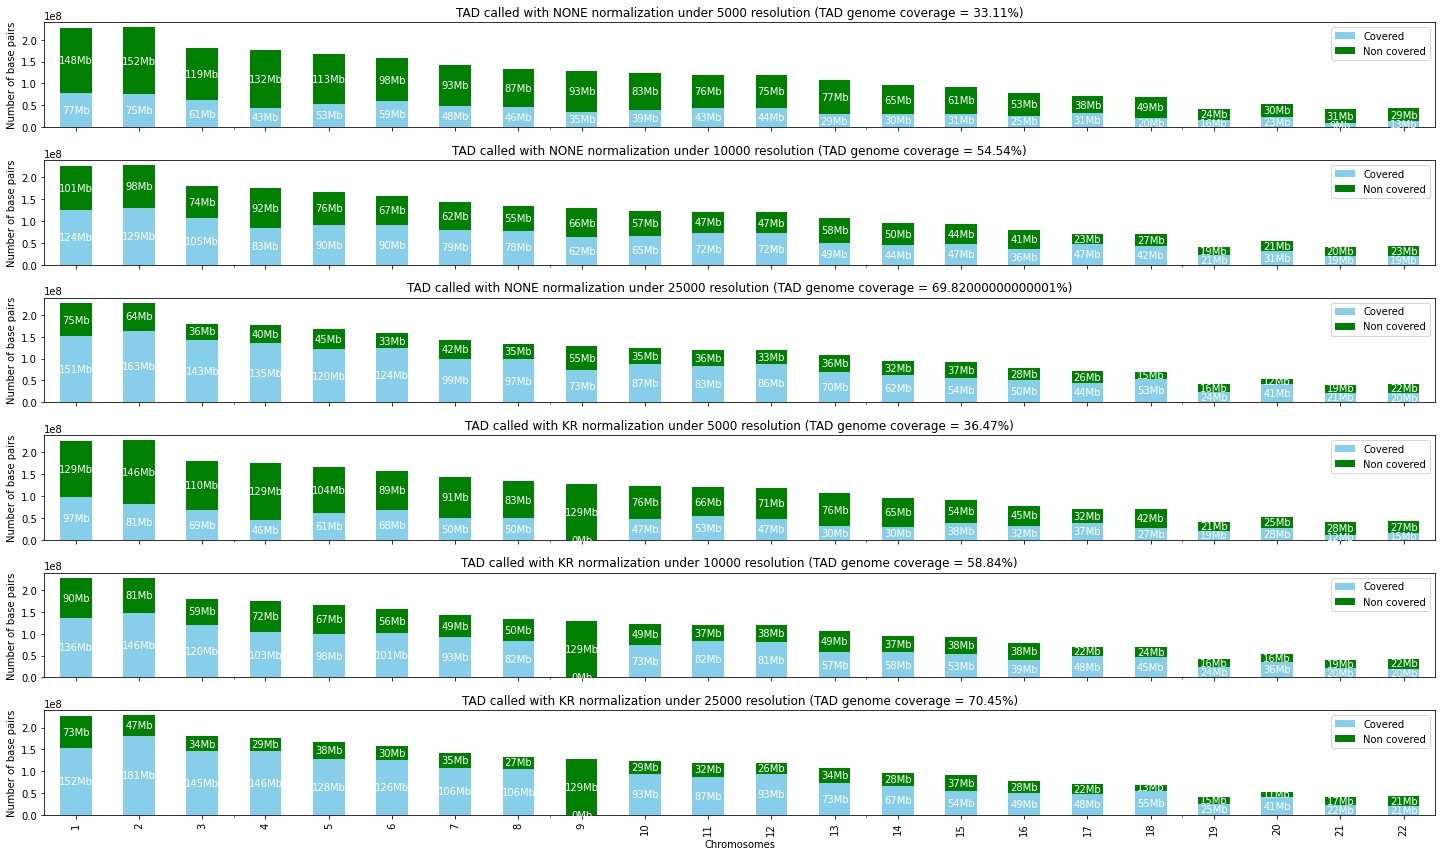

In [44]:
# Barplot of the number of base pairs covered by TADs for each chromosome
fig, axes = plt.subplots(nrows=len(processed_tads_dict.keys()), ncols=1, figsize=(20, 12), 
                         sharex=True, sharey=True)

# Plot the histograms on each subplot
for i, k in enumerate(processed_tads_dict.keys()):
    # Draw stacked barplot
    _, normalization, resolution = k.split('_')
    
    processed_tads_df = processed_tads_dict[k]
    processed_tads_df = processed_tads_df[['chromo', 'start', 'end']].copy()
    processed_tads_df.columns = ['chrom', 'start', 'end']
    processed_tads_df.loc[:, 'chrom'] = 'chr'+processed_tads_df['chrom'].astype(str)
    processed_tads_df.loc[:, 'name'] = 'tad_'+processed_tads_df['chrom'].astype(str)+'_'
    processed_tads_df.loc[:, 'name'] = processed_tads_df.loc[:, 'name'] + processed_tads_df['start'].astype(str)+'_'
    processed_tads_df.loc[:, 'name'] = processed_tads_df.loc[:, 'name']+processed_tads_df['end'].astype(str)
    processed_tads_bed = pybedtools.BedTool.from_dataframe(processed_tads_df)
    processed_tads_bed = processed_tads_bed.sort()

    # Intersect
    out = processed_tads_bed.intersect(non_blacklisted_bed)
    out = out.to_dataframe()
    out.loc[:, 'chrom'] = out['chrom'].str.strip('chr').astype(int)
    out.loc[:, 'length'] = out['end']-out['start']
    out = out[['chrom', 'start', 'end', 'length']]
    out = out.groupby('chrom')['length'].sum().to_frame('Covered')
    # Check if all chromosomes are present -- if not, add 0 size
    for chrom in list(set(chromosomes_list)-set(out.index)):
        out.loc[chrom, :] = [0]
    out.loc[:, 'Non covered'] = non_blacklisted_df_per_chrom['Non blacklisted']-out['Covered']
    out = out.sort_index().astype(int)
    # Compute proportion of non-blacklisted genome covered by TADs
    n_bp_genome = out.sum().sum()
    n_bp_covered = out['Covered'].sum()
    prop_bp_covered = np.round(n_bp_covered/n_bp_genome, 4)*100
    
    out.plot(
        kind='bar', 
        stacked=True, 
        color=['skyblue', 'green'],
        
        ax=axes[i]
    )
    axes[i].set_ylabel('Number of base pairs')
    axes[i].set_title(f'TAD called with {normalization} normalization under {resolution} resolution (TAD genome coverage = {prop_bp_covered}%)')
    
    # Add values
    for container in axes[i].containers:
        for rect in container:
            width = rect.get_width()
            height = rect.get_height()
            x = rect.get_x() + width / 2
            y = rect.get_y() + height / 2
            label = f"{int(height//1000000)}Mb"
            axes[i].annotate(label, (x, y), ha='center', va='center', color='w')

# Set common x-axis label
plt.xlabel('Chromosomes')

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()